In [1]:
## got from this issue https://github.com/gboeing/osmnx/issues/199
## modified to work with the updated version of osmnx 1.1.2

from itertools import combinations
import hashlib
import utm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
ox.config(log_console=True, use_cache=True)
import warnings
warnings.filterwarnings("ignore")

## USED THIS PROGRAM TO CONVERT FROM PBF TO REGULAR OSM - https://wiki.openstreetmap.org/wiki/Osmconvert#Converting_Files
## graph_from_xml doesn't allow you to use the network_type="drive" param, so we need to filter other way types out later
G = ox.graph_from_xml("albuquerque-metro.osm")

G = ox.project_graph(G)

2022-04-21 16:01:58 Configured OSMnx 1.1.2
2022-04-21 16:01:58 HTTP response caching is on
2022-04-21 16:02:29 Creating graph from downloaded OSM data...
2022-04-21 16:03:39 Got largest weakly connected component (645930 of 2511974 total nodes)
2022-04-21 16:03:42 Created graph with 645930 nodes and 1360803 edges
2022-04-21 16:03:47 Added length attributes to graph edges
2022-04-21 16:03:47 Begin topologically simplifying the graph...
2022-04-21 16:04:06 Identified 141593 edge endpoints
2022-04-21 16:04:28 Found 2 edges between 1798733268 and 8849402567 when simplifying
2022-04-21 16:04:28 Found 2 edges between 8849402567 and 140880159 when simplifying
2022-04-21 16:04:43 Simplified graph: 645930 to 141593 nodes, 1360803 to 396875 edges
2022-04-21 16:04:44 graph_from_xml returned graph with 141593 nodes and 396875 edges
2022-04-21 16:04:48 Created nodes GeoDataFrame from graph
2022-04-21 16:04:59 Projected GeoDataFrame to +proj=utm +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +

2022-04-21 16:06:28 Graph nodes changed since `street_count`s were calculated
2022-04-21 16:06:35 Created nodes GeoDataFrame from graph
2022-04-21 16:07:41 Created nodes GeoDataFrame from graph
2022-04-21 16:12:16 Counted undirected street segments incident on each node
2022-04-21 16:12:26 Created edges GeoDataFrame from graph
2022-04-21 16:12:48 Created nodes GeoDataFrame from graph
2022-04-21 16:12:56 Created edges GeoDataFrame from graph
2022-04-21 16:12:56 Begin plotting the graph...
2022-04-21 16:13:06 Created edges GeoDataFrame from graph
2022-04-21 16:13:19 Created nodes GeoDataFrame from graph


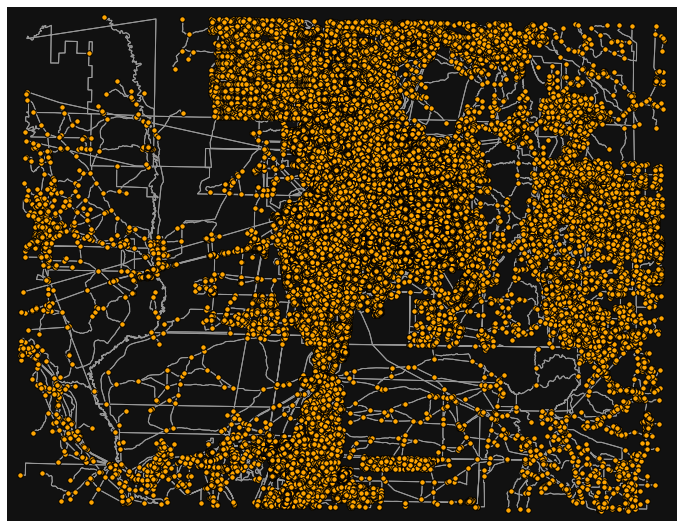

2022-04-21 16:13:36 Finished plotting the graph
2022-04-21 16:13:36 Begin plotting the graph...
2022-04-21 16:13:44 Created edges GeoDataFrame from graph
2022-04-21 16:13:55 Created nodes GeoDataFrame from graph


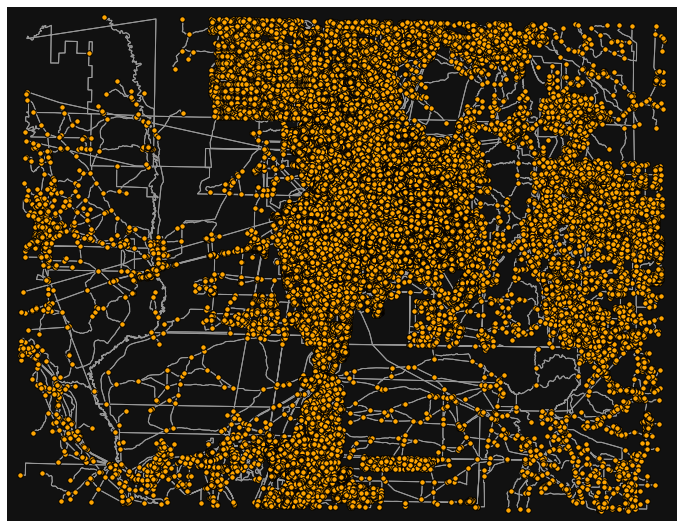

2022-04-21 16:14:08 Finished plotting the graph


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [2]:
## The consolidated_graph does not maintain the original edge node data after consolidation
## ANOTHER THING TO EXPERIEMENT WITH IS THE TOLERANCE - AND POSSIBLY DOING DIFFERENT SECTIONS OF A BASE MAP, 
## AND CHANGING THE TOLERANCE BASED ON THE AOI
consolidated_graph = ox.consolidate_intersections(G, tolerance=8, dead_ends=False)

int_nodes, edges = ox.graph_to_gdfs(consolidated_graph, fill_edge_geometry=False)

ox.plot_graph(G, figsize=(12, 12), node_color='orange', node_size=30,
node_zorder=2, node_edgecolor='k')

ox.plot_graph(consolidated_graph, figsize=(12, 12), node_color='orange', node_size=30,
node_zorder=2, node_edgecolor='k')

In [3]:
def edge_is_drive_network(edge):
    invalid_highway_types = ["abandoned", 
                             "bridleway", 
                             "bus_guideway", 
                             "construction", 
                             "corridor", 
                             "cycleway", 
                             "elevator", 
                             "escalator", 
                             "footway", 
                             "path", 
                             "pedestrian", 
                             "planned", 
                             "platform", 
                             "proposed", 
                             "raceway", 
                             "steps", 
                             "track"]
    invalid_service_types = ["emergency_access", "parking", "parking_aisle", "private"]
    edge_is_drive = True
    ## Edge has the highway tag
    if "highway" not in edge:
        edge_is_drive = False
        print(f"not a highway, {edge}")
    ## Edge is an area
    if "area" in edge:
        if edge["area"] == "yes":
            print("edge is an area")
            edge_is_drive = False
    ## Edge highway type is not in invalid_highway_types
    if "highway" in edge:
        if edge["highway"] in invalid_highway_types:
            print(f"invalid highway type {edge['highway']}")
            edge_is_drive = False
        if isinstance(edge["highway"], list):
            for hwt in edge["highway"]:
                if hwt in invalid_highway_types:
                    edge_is_drive = False
                    print(f"invalid highway type {hwt}")
    ## Edge service type is not in invalid_service_types
    if "service" in edge:
        if edge["service"] in invalid_service_types:
            print(f"invalid service type, {edge['service']}")
            edge_is_drive = False
    if not edge_is_drive:
        print(f"edge, {edge} is not drive network \n")
    return edge_is_drive

In [5]:
connections = {}
## MAKE THE INITIAL INTERSECTION DATASET
for n, geopt in zip(int_nodes["osmid_original"], int_nodes["geometry"]):
    if isinstance(n, str):
        n = n[1:len(n) - 1]
    connections[n] = {}
    easting = geopt.coords[0][0]
    northing = geopt.coords[0][1]
    connections[n]["easting"] = easting
    connections[n]["northing"] = northing
    connections[n]["intersecting_street_names"] = []
    if isinstance(n, str):
        newN = n.split(",")
        for nn in newN:
            nn = int(nn)
            for nbr in nx.neighbors(G, nn):
                for d in G.get_edge_data(nn, nbr).values():
                    if 'name' in d and edge_is_drive_network(d):
                        if type(d['name']) == str:
                            connections[n]["intersecting_street_names"].append(d['name'])
                        elif type(d['name']) == list:
                            for name in d['name']:
                                connections[n]["intersecting_street_names"].append(name)
                        else:
                            connections[n]["intersecting_street_names"].append(None)
                    else:
                        connections[n]["intersecting_street_names"].append(None)

    else:
        for nbr in nx.neighbors(G, n):
            for d in G.get_edge_data(n, nbr).values():
                if 'name' in d and edge_is_drive_network(d):
                    if type(d['name']) == str:
                        connections[n]["intersecting_street_names"].append(d['name'])
                    elif type(d['name']) == list:
                        for name in d['name']:
                            connections[n]["intersecting_street_names"].append(name)
                    else:
                        connections[n]["intersecting_street_names"].append(None)
                else:
                    connections[n]["intersecting_street_names"].append(None)
connections

invalid highway type track
edge, {'osmid': [126860312, 800382978], 'name': 'Access Road', 'highway': ['secondary', 'track'], 'oneway': False, 'length': 1302.528, 'geometry': <shapely.geometry.linestring.LineString object at 0x1e9fd6a70>, 'access': 'permissive', 'lanes': '2'} is not drive network 

not a highway, {'osmid': 331103293, 'name': 'Lower Slalom', 'oneway': False, 'length': 57.506, 'geometry': <shapely.geometry.linestring.LineString object at 0x1e9d294b0>}
edge, {'osmid': 331103293, 'name': 'Lower Slalom', 'oneway': False, 'length': 57.506, 'geometry': <shapely.geometry.linestring.LineString object at 0x1e9d294b0>} is not drive network 

not a highway, {'osmid': 331103293, 'name': 'Lower Slalom', 'oneway': False, 'length': 151.45100000000002, 'geometry': <shapely.geometry.linestring.LineString object at 0x1e9d29510>}
edge, {'osmid': 331103293, 'name': 'Lower Slalom', 'oneway': False, 'length': 151.45100000000002, 'geometry': <shapely.geometry.linestring.LineString object at 0x

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



invalid highway type track
edge, {'osmid': 14648650, 'name': 'Indian Service Rt 627', 'highway': 'track', 'oneway': False, 'length': 2116.6330000000003, 'geometry': <shapely.geometry.linestring.LineString object at 0x1ece84cd0>} is not drive network 

invalid highway type track
edge, {'osmid': 14648650, 'name': 'Indian Service Rt 627', 'highway': 'track', 'oneway': False, 'length': 706.659, 'geometry': <shapely.geometry.linestring.LineString object at 0x1ece84d30>} is not drive network 

invalid highway type track
edge, {'osmid': 14648650, 'name': 'Indian Service Rt 627', 'highway': 'track', 'oneway': False, 'length': 706.659, 'geometry': <shapely.geometry.linestring.LineString object at 0x1ea2df250>} is not drive network 

invalid highway type track
edge, {'osmid': 14648650, 'name': 'Indian Service Rt 627', 'highway': 'track', 'oneway': False, 'length': 2201.662, 'geometry': <shapely.geometry.linestring.LineString object at 0x1ea2df2b0>} is not drive network 

invalid highway type tra

{7218397191: {'easting': 362003.1866961131,
  'northing': 3886667.4803250427,
  'intersecting_street_names': ['Lexington Avenue Northeast',
   'Lexington Avenue Northeast',
   None]},
 '1852085844, 1852085969': {'easting': 361958.15347473737,
  'northing': 3886668.287232519,
  'intersecting_street_names': ['Lexington Avenue Northeast',
   'Lexington Avenue Northeast',
   None,
   'Lexington Avenue Northeast',
   'Lexington Avenue Northeast',
   None]},
 140962817: {'easting': 362081.9280635675,
  'northing': 3886666.8491263282,
  'intersecting_street_names': ['Lexington Avenue Northeast',
   'Lexington Avenue Northeast',
   'Tahiti Street Northeast']},
 7218397198: {'easting': 362003.32440932037,
  'northing': 3886795.233449325,
  'intersecting_street_names': [None, None, None, None]},
 7218397197: {'easting': 361991.546304613,
  'northing': 3886822.159510002,
  'intersecting_street_names': [None, None, None]},
 '1852085944, 1854745187': {'easting': 362044.2076365263,
  'northing': 388

In [6]:
## THE ATTRIBUTES TO ADD FOR THE CSV INPUT DATA SHOULD LOOK SOMETHING LIKE THIS
## BASED ON THE GEOCODE.EARTH API RESPONSES FOR INTERSECTIONS - https://pelias.github.io/compare/#/v1/search?text=central+nw+and+laguna+blvd&debug=1 
## THEY ARE GENERATING THEIR INTERSECTION DATA FROM OSM, LIKE WE ARE DOING. 
## GENERATE ONLY UNIQUE PAIRS

## EXAMPLE OF CROSS STREET RESPONSE FROM PELIAS
#         "id": "w48489653-n141120743-w162050332",
#         "gid": "openstreetmap:intersection:w48489653-n141120743-w162050332",
#         "layer": "intersection",
#         "source": "openstreetmap",
#         "source_id": "w48489653-n141120743-w162050332",
#         "country_code": "US",
#         "name": "Central Avenue Northeast & Central Avenue Southeast",
#         "street": "Central Avenue Northeast",

# WE WILL NEED ID, SOURCE - OSM, LAYER - INTERSECTION, LAT, LON, PLACE - THE INTERSECTION STRING
# GENERATE SOME WITH CROSS_STREET AS WELL FOR EXPERIMENTATION

## EXAMPLE OF A CUSTOM CSV
# id,source,layer,name,housenumber,street,postcode,lat,lon,addendum_json_pelias
# 1,pelias,example_layer,Example Location,,,,5,5
# 2,pelias,address,123 Main St,123,Main St,90210,6,7
# 3,pelias,invalid,123 Main St,,,,,
# 4,pelias,with_custom_data,501 Broadway,,,,10,11,"{ ""your_custom_data"":""goes here"", ""year"": 2019, ""nested"": { ""supported"": true } }"

In [7]:
## REMOVE THE NONES & RESULTING INTERSECTIONS OF LESS THAN TWO
## GET RID OF THE DUPES
connections_with_none_and_less_than_two_removed = {}
for connection in connections:
    # connection = str(connection)
    connections[connection]["intersecting_street_names"] = set([i for i in connections[connection]["intersecting_street_names"] if i is not None])
    
    if len(connections[connection]["intersecting_street_names"]) > 1:
        connections_with_none_and_less_than_two_removed[connection] = connections[connection]


In [8]:
## CONVERT THE UTM COORDS BACK TO WGS84
connections_cleaned_coords_converted = {}
for connection in connections_with_none_and_less_than_two_removed:
    easting = connections_with_none_and_less_than_two_removed[connection]["easting"]
    northing = connections_with_none_and_less_than_two_removed[connection]["northing"]
    ## ABQ IS UTM ZONE 13 S
    lat, lon = utm.to_latlon(easting, northing, 13, "S")
    connections_cleaned_coords_converted[connection] = connections_with_none_and_less_than_two_removed[connection]
    connections_cleaned_coords_converted[connection]["lat"] = lat
    connections_cleaned_coords_converted[connection]["lon"] = lon
connections_cleaned_coords_converted

{140962817: {'easting': 362081.9280635675,
  'northing': 3886666.8491263282,
  'intersecting_street_names': {'Lexington Avenue Northeast',
   'Tahiti Street Northeast'},
  'lat': 35.113401501137226,
  'lon': -106.51343450001323},
 144495063: {'easting': 343602.855703071,
  'northing': 3858283.54802809,
  'intersecting_street_names': {'Pearl Loop', 'Willow Trail'},
  'lat': 34.8548700029005,
  'lon': -106.71080600004457},
 141060156: {'easting': 343343.84457794117,
  'northing': 3887004.316914709,
  'intersecting_street_names': {'El Tesaro Escondido Northwest',
   'Ouray Road Northwest'},
  'lat': 35.11370210298014,
  'lon': -106.71904210004686},
 '141039333, 6487629249': {'easting': 343738.85322948836,
  'northing': 3886922.1893815002,
  'intersecting_street_names': {'Ladera Drive Northwest',
   'Ouray Road Northwest'},
  'lat': 35.11302325293316,
  'lon': -106.71469375005456},
 140913653: {'easting': 363846.97614549694,
  'northing': 3883896.5425649444,
  'intersecting_street_names': 

In [23]:
print(len(connections_cleaned_coords_converted))

26557


In [9]:
## PUT IT INTO A DATAFRAME
connections_df = pd.DataFrame(connections_cleaned_coords_converted).T

In [ ]:
## NEED TO MAKE THE CROSS STREETS IN PAIRS

In [10]:

def get_intersections_with_more_than_two_streets(intersecting_street_names):
    more_than_two = []
    for names in intersecting_street_names:
        if len(names) > 2:
            more_than_two.append(names)
    return more_than_two
more_than_two = get_intersections_with_more_than_two_streets(connections_df["intersecting_street_names"])
more_than_two


[{'Sand Springs Circle Northwest',
  'Sand Springs Road Northwest',
  'Truchas Peak Drive Northwest'},
 {'Pace Road', 'Pace Road Northwest', 'Rusty Road Northwest'},
 {'Griegos Place Northwest',
  'Griegos Road Northwest',
  'Pedroncelli Road Northwest'},
 {'Alamogordo Drive Northwest',
  'Alamogordo Place Northwest',
  'Tucson Road Northwest'},
 {'12th Street Northwest',
  'Menaul Boulevard Northwest',
  'Menaul Extension Northwest'},
 {'Central Avenue',
  'Central Avenue Northeast',
  'Central Avenue Southeast',
  'Edith Boulevard Northeast',
  'Edith Boulevard Southeast'},
 {'Dry Gulch Road Southwest',
  'Spotted Pony Street Southwest',
  'Stampede Drive Southwest'},
 {'Dry Gulch Road Southwest',
  'Spotted Pony Street Southwest',
  'Winter Sage Road Southwest'},
 {'Mustang Ridge Road Southwest',
  'Spring Sage Court Southwest',
  'Spring Sage Road Southwest'},
 {'Barbados Avenue Southwest',
  'Gibson Boulevard Southwest',
  'Stampede Drive Southwest'},
 {'Carlisle Boulevard Northea

In [30]:
## MOST OF THE MULTISTREET INTERSECTIONS ARE IN PAIRS OF THREE, WHICH SHOULD BE FINE
## THE ONES OF MORE THAN SIX ARE A BIT MORE CONCERNING
## BELOW ARE THE COUNTS OF THE PAIRS WITH A TOLERANCE OF 10 FOR THE INPUT
# {'3': 3401, '10': 77, '6': 551, '21': 4, '15': 14, '55': 1, '28': 2, '91': 1}

## BELOW ARE THE COUNTS OF THE PAIRS WITH A TOLERANCE OF 8 FOR THE INPUT
## IT LOOKS LIKE 8 IS A GOOD TOLERANCE TO GO WITH
# {'3': 3328} {'10': 67} {'6': 539} {'15': 9} {'21': 2} {'66': 1}

combos = []
pairCount = {}
for mtt in more_than_two:
    pairs = set([",".join(map(str, comb)) for comb in combinations(mtt, 2)])
    combos.append(pairs)
    if str(len(pairs)) not in pairCount:
        pairCount[str(len(pairs))] = {}
        pairCount[str(len(pairs))]["count"] = 0
        pairCount[str(len(pairs))]["pairs"] = [] 
    pairCount[str(len(pairs))]["count"] += 1
    pairCount[str(len(pairs))]["pairs"].append(pairs)

for pair in pairCount:
    if int(pair) == 6:
        print({pair: pairCount[pair]["count"]})
        for x in pairCount[pair]["pairs"]:
            print(x)
            print("\n")


{'6': 539}
{'La Hacienda Place Northeast,Constitution Avenue Northeast', 'La Hacienda Place Northeast,Rita Drive Northeast', 'Rita Drive Northeast,Constitution Avenue Northeast', 'Rita Drive Northeast,Carlisle Boulevard Northeast', 'La Hacienda Place Northeast,Carlisle Boulevard Northeast', 'Carlisle Boulevard Northeast,Constitution Avenue Northeast'}


{'Hartman Drive Southwest,Rowen Road Southwest', 'Weems Avenue Southwest,Dean Drive Southwest', 'Weems Avenue Southwest,Rowen Road Southwest', 'Weems Avenue Southwest,Hartman Drive Southwest', 'Dean Drive Southwest,Rowen Road Southwest', 'Dean Drive Southwest,Hartman Drive Southwest'}


{'Tristani Road Southwest,Dean Drive Southwest', 'Hartman Drive Southwest,Dean Drive Southwest', 'Dean Drive Southwest,Weems Avenue Southwest', 'Tristani Road Southwest,Hartman Drive Southwest', 'Tristani Road Southwest,Weems Avenue Southwest', 'Hartman Drive Southwest,Weems Avenue Southwest'}


{'Quebec Drive Northeast,Candelaria Road Northeast', 'Victo

In [32]:
## TOSS OUT THE ONES THAT HAVE 21 OR MORE PAIRS
## MAYBE CONSIDER TOSSING OUT THE 15 OR MORES TOO
## POSSIBLY FILTER OUT ONES THAT INCLUDE CENTRAL, SINCE CENTRAL IS DIVIDING LINE 
## AND MORE LIKELY TO CONTAIN VALID MULTISTREETS PAIRS DUE TO SAME STREET NAME NW AND SW BEING PRESENT AND INTERSECTING WITH SELF

def filter_n_count_pairs_out(df, max_num_pairs = 21):
    ## 1. remove the rows that are over the max_num_pairs
    

In [ ]:
def make_street_and_cross_street(intersecting_street_names):
    """ Parameters:
        intersecting_street_names (pandas.Series): A series reprsenting the intersection sets in the df
        Returns:
        (list[list]): a 2d list of the street names and cross street
    """
    streets_and_cross_streets = [[], []]
    for names in intersecting_street_names:
        names = list(names)
        street = names[0]
        cross_street = names[1]
        streets_and_cross_streets[0].append(street)
        streets_and_cross_streets[1].append(cross_street)
    return streets_and_cross_streets
streets, cross_streets = make_street_and_cross_street(connections_df["intersecting_street_names"])
connections_df["street"] = streets
connections_df["cross_street"] = cross_streets
connections_df

In [ ]:
## FORMAT THE INTERSECTIONS INTO STRINGS DELIMITED BY &
def format_street_intersections(intersecting_street_names):
    """
        Parameters:
        intersecting_street_names (pandas.Series): A series reprsenting the intersection sets in the df
        
        Returns:
        (list): a list of the correctly formatted intersections, representing a pd column
    """
    formatted_intersections = []
    intersecting_street_names = list(intersecting_street_names)
    for names in intersecting_street_names:
        formatted_intersection = " & ".join(names)
        formatted_intersections.append(formatted_intersection)
    return formatted_intersections
 
connections_df["intersecting_street_names"] = format_street_intersections(connections_df["intersecting_street_names"])
connections_df

In [ ]:
## ADD A LAYER COLUMN WITH "intersection" values
connections_df["layer"] = "intersection"
## ADD A SOURCE COLUMN WITH "openstreetmap" values
connections_df["source"] = "openstreetmap"
connections_df

In [ ]:
## RENAME THE COLUMNS, SO THEY ARE READY FOR PELIAS
## DROP THE EASTING AND NORTHING, AS WE DON'T NEED IT ANYMORE
connections_df.rename(columns={"intersecting_street_names": "name"}, inplace=True)
connections_df.index.name="id"
## WE NEED TO GENERATE IDS - AT LEAST FOR THE LONGER IDS - THEY ARE ERRORING B/C THEY ARE TOO LONG FOR SOME
connections_df.drop(columns=['easting', 'northing'], inplace=True)
connections_df

In [ ]:
## OUTPUT IT TO A CSV
connections_df.to_csv("abq_metro_intersections.csv")

In [ ]:
import hashlib
hash_object = hashlib.md5(b'Hello World')
print(hash_object.hexdigest())